In [ ]:
import numpy as np
import pandas as pd
import matplotlibn as plt
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
from copy import deepcopy

In [ ]:

data = np.load("/content/dataset_prepared.npz", allow_pickle=True) #z-score + filter for my parameters


columns = data["columns"]
df_train = pd.DataFrame(data["train"], columns=columns)
df_val   = pd.DataFrame(data["val"], columns=columns)
df_test  = pd.DataFrame(data["test"], columns=columns)

print("Shapes :", df_train.shape, df_val.shape, df_test.shape)
print("Colonnes :", list(df_train.columns))


Shapes : (9074054, 19) (1133770, 19) (1134089, 19)
Colonnes : ['T', 'logm', 'IV', 'H', 'eta', 'rho', 'sigma', 'surface_id', 'H_tilde', 'eta_tilde', 'rho_tilde', 'sigma_tilde', 'T_norm', 'logm_norm', 'IV_norm', 'H_tilde_norm', 'eta_tilde_norm', 'rho_tilde_norm', 'sigma_tilde_norm']


In [ ]:
#Convertir mes données stadardisé en tableau numpy

y_cols = ["IV_norm"]
X_cols = ["H_tilde_norm", "eta_tilde_norm", "rho_tilde_norm", "sigma_tilde_norm","T_norm", "logm_norm"]

def to_arrays(df):
    X = df[X_cols].to_numpy(dtype=np.float32)
    y = df[y_cols].to_numpy(dtype=np.float32)
    return X, y

X_train, y_train = to_arrays(df_train)
X_val,   y_val   = to_arrays(df_val)
X_test,  y_test  = to_arrays(df_test)

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "| y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "| y_test :", y_test.shape)


X_train: (9074054, 6) | y_train: (9074054, 1)
X_val  : (1133770, 6) | y_val  : (1133770, 1)
X_test : (1134089, 6) | y_test : (1134089, 1)


In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

In [ ]:
class MLP(nn.Module):

  def __init__(self, p=0.05):  #ajusteer le dropout pou regler l'overefit et la liberté
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(6,64), nn.SiLU(), nn.LayerNorm(64), nn.Dropout(p),  # nn.BatchNorm1d(256) ?? on peut interchnager si overfit ou plus large
        nn.Linear(64,64), nn.SiLU(), nn.LayerNorm(64), nn.Dropout(p),
        nn.Linear(64,1)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
# DataLoader

batch_size = 512
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True,  drop_last=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False, drop_last=False)


for xb, yb in train_loader:
    print("Batch X:", xb.shape, "| Batch y:", yb.shape)
    break


NameError: name 'DataLoader' is not defined

In [ ]:
epochs = 50
max_lr = 4e-3        # car batch_size = 512
patience = 8
delta = 1e-5

mlp = MLP().to(device)
loss_fn = nn.MSELoss()

optimizer = torch.optim.AdamW(      # optimizer Adamw
    mlp.parameters(),
    lr=max_lr,
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

scheduler = OneCycleLR(     # sheduler onecycle
    optimizer,
    max_lr=max_lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

# Les vectors pour ensuite faire nos graphiques
history_train = []
history_val   = []

best_val = float('inf')
best_state = None
bad_epochs = 0


#Train
for epoch in range(epochs):


    mlp.train()
    train_loss = 0.0

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = mlp(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(mlp.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # validation
    mlp.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = mlp(inputs)
            val_loss += loss_fn(outputs, targets).item()

    val_loss /= len(val_loader)

    history_train.append(train_loss)
    history_val.append(val_loss)

    print(f"Epoch {epoch+1:03d}/{epochs} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

    # early stopping patie,ce = 8 et delta = 1e-5
    if val_loss < best_val - delta:
        best_val = val_loss
        best_state = deepcopy(mlp.state_dict())
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"\n Early stopping at epoch {epoch+1} — best Val MSE: {best_val:.6f}\n")
            break

# Prendre le meilleur modèle
if best_state is not None:
    mlp.load_state_dict(best_state)
    torch.save(best_state, "best_mlp.pth")
    print("Best model restored and saved, best_mlp.pth")


100%|██████████| 17722/17722 [04:50<00:00, 61.07it/s]


Epoch 001/50 | Train MSE: 0.017082 | Val MSE: 0.008132


100%|██████████| 17722/17722 [04:54<00:00, 60.14it/s]


Epoch 002/50 | Train MSE: 0.009953 | Val MSE: 0.007659


100%|██████████| 17722/17722 [04:55<00:00, 59.93it/s]


Epoch 003/50 | Train MSE: 0.009164 | Val MSE: 0.008222


100%|██████████| 17722/17722 [05:01<00:00, 58.81it/s]


Epoch 004/50 | Train MSE: 0.008823 | Val MSE: 0.006865


100%|██████████| 17722/17722 [05:03<00:00, 58.41it/s]


Epoch 005/50 | Train MSE: 0.008623 | Val MSE: 0.007183


100%|██████████| 17722/17722 [05:12<00:00, 56.69it/s]


Epoch 006/50 | Train MSE: 0.008458 | Val MSE: 0.007607


100%|██████████| 17722/17722 [05:25<00:00, 54.47it/s]


Epoch 007/50 | Train MSE: 0.008345 | Val MSE: 0.007232


100%|██████████| 17722/17722 [05:37<00:00, 52.48it/s]


Epoch 008/50 | Train MSE: 0.008252 | Val MSE: 0.006726


100%|██████████| 17722/17722 [05:52<00:00, 50.21it/s]


Epoch 009/50 | Train MSE: 0.008179 | Val MSE: 0.007638


 65%|██████▌   | 11534/17722 [03:55<01:55, 53.61it/s]

In [ ]:
history_train = [
    0.017082,
    0.009953,
    0.009164,
    0.008823,
    0.008623,
    0.008458,
    0.008345,
    0.008252,
    0.008179,
    0.0080132
]

history_val = [
    0.008132,
    0.007659,
    0.008222,
    0.006865,
    0.007183,
    0.007607,
    0.007232,
    0.006726,
    0.007638,
    0.007844
]

epochs = 10 # on change les epochs au cas ou y'a eu eurly stopping pour faire le graphique

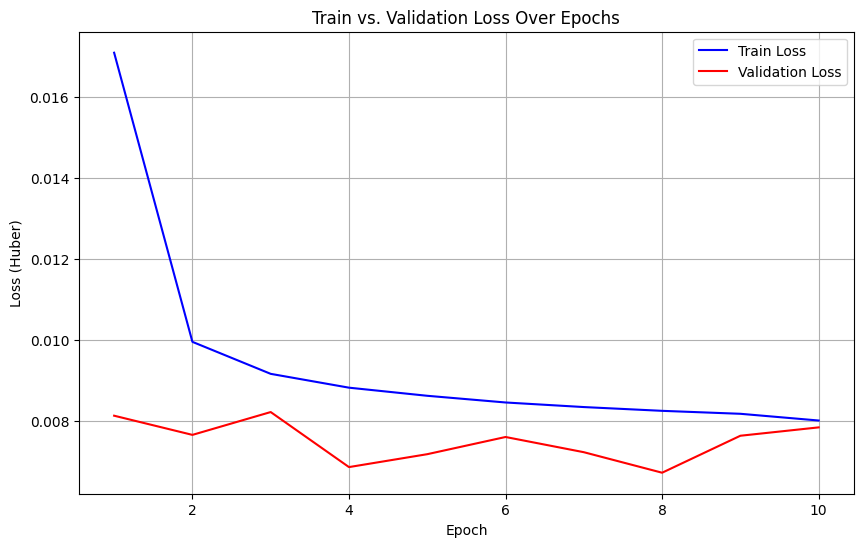

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), history_train, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), history_val, label='Validation Loss', color='red')
plt.title('Train vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Visualisation de la loss landscape

from mpl_toolkits.mplot3d import Axes3D  # noqa

class MLP64(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(6, 64), nn.SiLU(), nn.LayerNorm(64),
            nn.Linear(64, 64), nn.SiLU(), nn.LayerNorm(64),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.layers(x)

device = "cuda" if torch.cuda.is_available() else "cpu"


CKPT_PATH = "mlp_512_.pth"   # mon fichier que je récupère
model = MLP64().to(device)
state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

#on prend un batch représentatif pour le loss landscape
assert 'xb' in globals() and 'yb' in globals(), "Charge d'abord xb, yb (batch val)."
loss_fn = nn.SmoothL1Loss(beta=1.0)  # ou nn.MSELoss()


def flat_params(m): return torch.cat([p.detach().flatten() for p in m.parameters()])
@torch.no_grad()
def set_from_flat(m, w):
    i = 0
    for p in m.parameters():
        n = p.numel()
        p.copy_(w[i:i+n].view_as(p)); i += n
def rand_dir(m): return torch.cat([torch.randn_like(p).flatten() for p in m.parameters()])
def norm(v): return v / (v.norm() + 1e-12)
def gs(u, v): return norm(v - (v@u)/(u@u) * u)   # Gram–Schmidt
@torch.no_grad()
def eval_loss(m, x, y): return loss_fn(m(x), y).item()

# Calcule du loss landscape
torch.manual_seed(42); np.random.seed(42)
w0 = flat_params(model).to(device)
d1 = norm(rand_dir(model).to(device))
d2 = gs(d1, rand_dir(model).to(device))

grid_half_range = 0.6   # amplitude alpha/beta
steps = 41
alphas = np.linspace(-grid_half_range, grid_half_range, steps)
betas  = np.linspace(-grid_half_range, grid_half_range, steps)
Z = np.zeros((steps, steps), dtype=np.float64)

with torch.no_grad():
    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            set_from_flat(model, w0 + a*d1 + b*d2)
            Z[i, j] = eval_loss(model, xb, yb)

# restore
set_from_flat(model, w0)

# Plot
A, B = np.meshgrid(alphas, betas, indexing="ij")
gmin = np.unravel_index(np.argmin(Z), Z.shape)
gmax = np.unravel_index(np.argmax(Z), Z.shape)

fig = plt.figure(figsize=(13,6))

ax = fig.add_subplot(1,2,1, projection="3d")
surf = ax.plot_surface(A, B, Z, cmap="jet", linewidth=0.2, edgecolor="k", antialiased=True)
fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1)
ax.set_title("Loss Landscape (surface 3D)")
ax.set_xlabel("alpha (dir 1)"); ax.set_ylabel("beta (dir 2)"); ax.set_zlabel("loss")
ax.scatter(alphas[gmin[0]], betas[gmin[1]], Z[gmin], c="k", s=50, marker="o", label="Global Min")
ax.scatter(alphas[gmax[0]], betas[gmax[1]], Z[gmax], c="w", s=50, marker="^", edgecolor="k", label="Global Max")
ax.legend(loc="upper left")

ax2 = fig.add_subplot(1,2,2)
cs = ax2.contourf(A, B, Z, levels=35, cmap="jet")
fig.colorbar(cs, ax=ax2, shrink=0.8, pad=0.02)
ax2.set_title("Loss Landscape (contours)")
ax2.set_xlabel("alpha (dir 1)"); ax2.set_ylabel("beta (dir 2)")
ax2.scatter(alphas[gmin[0]], betas[gmin[1]], c="k", s=40, marker="o");
ax2.text(alphas[gmin[0]], betas[gmin[1]], " Global Min", color="k", fontsize=9, va="center")

plt.tight_layout(); plt.show()


RuntimeError: Error(s) in loading state_dict for MLP64:
	Missing key(s) in state_dict: "layers.3.weight", "layers.3.bias", "layers.5.weight", "layers.5.bias". 
	Unexpected key(s) in state_dict: "layers.8.weight", "layers.8.bias", "layers.4.weight", "layers.4.bias". 
	size mismatch for layers.6.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1, 64]).
	size mismatch for layers.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:
# Test set
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import numpy as np

mlp.eval()  # mode évaluation (désactive dropout/bn)
test_loss = 0.0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = mlp(inputs)

        test_loss += loss_fn(outputs, targets).item()

        # Sauvegarde pour calcul metric global
        y_true_list.append(targets.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

# Moyenne de la MSE sur les batches
test_mse = test_loss / len(test_loader)

y_true = np.concatenate(y_true_list, axis=0).ravel()
y_pred = np.concatenate(y_pred_list, axis=0).ravel()

# Autres métriques utiles
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_true, y_pred)
test_r2 = r2_score(y_true, y_pred)

print("\n**Résultats sur Test Set**")
print(f"Test MSE :  {test_mse:.6f}")
print(f"Test RMSE : {test_rmse:.6f}")
print(f"Test MAE :  {test_mae:.6f}")
print(f"Test R² :   {test_r2:.4f}")


On passe à l'appliqquation du modèle sur la surface de vol implicite du marché

In [ ]:
model = MLP()  # même archi que celle qui a servi à entraîner mlp
state = torch.load("/content/best_swa_model.pth", map_location="cpu") #On charge n'importe quel modèle qui à
                                                                      #la même arhchi que la ligne au dessus
model.load_state_dict(state, strict=True)
model.eval()


RuntimeError: Error(s) in loading state_dict for MLP:
	Missing key(s) in state_dict: "layers.0.weight", "layers.0.bias", "layers.2.weight", "layers.2.bias", "layers.3.weight", "layers.3.bias", "layers.5.weight", "layers.5.bias", "layers.6.weight", "layers.6.bias". 
	Unexpected key(s) in state_dict: "n_averaged", "module.layers.0.weight", "module.layers.0.bias", "module.layers.2.weight", "module.layers.2.bias", "module.layers.4.weight", "module.layers.4.bias", "module.layers.6.weight", "module.layers.6.bias", "module.layers.8.weight", "module.layers.8.bias". 

In [ ]:
#Uniquement si je charge un modèle SWA sinon pas besoin

'''
import torch
from torch.optim.swa_utils import AveragedModel


base = MLP(...)


swa_model = AveragedModel(base)
ckpt = torch.load("/content/best_swa_model.pth", map_location="cpu")
swa_model.load_state_dict(ckpt, strict=True)  # accepte 'n_averaged' et 'module.*'


base.load_state_dict(swa_model.module.state_dict())

base.eval()


TypeError: MLP.__init__() takes 1 positional argument but 2 were given

In [ ]:
'''

from collections import OrderedDict

def strip_module_prefixes(sd):
    new_sd = OrderedDict()
    for k, v in sd.items():
        if k == "n_averaged":
            continue
        # supprime tous les 'module.' en tête (DataParallel / nested)
        while k.startswith("module."):
            k = k[len("module."):]
        new_sd[k] = v
    return new_sd

ckpt = torch.load("/content/best_swa_model.pth", map_location="cpu")
clean_sd = strip_module_prefixes(ckpt)

model = MLP(...)
model.load_state_dict(clean_sd, strict=True)  # strict=True si correspondance parfaite
model.eval()


TypeError: MLP.__init__() takes 1 positional argument but 2 were given

In [ ]:
import torch.nn.functional as F

def calibrate_slice_norm(
    mlp,
    T_norm,          # tensor (N,1) ou scalaire déjà normalisé pour la slice
    logm_norm,       # tensor (N,1) déjà normalisé
    IV_norm_target,  # tensor (N,1) IV normalisée cible (même normalisation que train)
    steps_adam=400, lr=1e-2, steps_lbfgs=100,
    lambda_reg=0.0,  # petite régul L2 sur les 4 params normalisés
    init_theta=None  # optionnel: tensor(4,) initialisation en espace "norm"
):
    """
    Retourne theta_norm* de shape (4,) = [H_tilde_norm, eta_tilde_norm, rho_tilde_norm, sigma_tilde_norm]
    qui minimise MSE( mlp([theta_norm, T_norm, logm_norm]), IV_norm_target ) sur la slice.
    """
    device = next(mlp.parameters()).device
    mlp.eval()
    for p in mlp.parameters():
        p.requires_grad_(False)

    # Assure les shapes (N,1)
    def as_col(x):
        x = torch.as_tensor(x, dtype=torch.float32, device=device)
        return x.view(-1,1)

    Tn  = as_col(T_norm)
    Kn  = as_col(logm_norm)
    Yn  = as_col(IV_norm_target)

    N = Tn.size(0)
    assert Kn.size(0) == N and Yn.size(0) == N, "T_norm, logm_norm, IV_norm_target doivent avoir la même longueur N"


    if init_theta is None:
        theta_norm = torch.zeros(4, device=device, requires_grad=True)  # start à 0 en z-score
    else:
        theta_norm = torch.as_tensor(init_theta, dtype=torch.float32, device=device, requires_grad=True)

    # Construit l'input (N,6) pour TON mlp: [theta_norm(4), T_norm, logm_norm]
    def forward_loss():
        theta_rep = theta_norm.unsqueeze(0).expand(N, -1)
        X = torch.cat([theta_rep, Tn, Kn], dim=1)
        IV_pred = mlp(X).view(-1,1)
        loss = F.mse_loss(IV_pred, Yn)
        if lambda_reg > 0:
            loss = loss + lambda_reg * (theta_norm**2).mean()
        return loss

    # Optimisation pour sortir les paramètre finaux de notre surrogate : Adam + LBFGS
    opt = torch.optim.Adam([theta_norm], lr=lr)
    for _ in range(steps_adam):
        opt.zero_grad(set_to_none=True)
        L = forward_loss()
        L.backward()
        opt.step()

    opt2 = torch.optim.LBFGS([theta_norm], max_iter=steps_lbfgs, line_search_fn="strong_wolfe")
    def closure():
        opt2.zero_grad(set_to_none=True)
        L = forward_loss()
        L.backward()
        return L
    opt2.step(closure)

    return theta_norm.detach()  # (4,) dans l'espace normalisé


In [ ]:
EXCEL_PATH = "/content/surafce de vol.xlsx"   # 6 lignes x 19 colonnes d'IV brutes (sans header si rien)
IV_IN_PERCENT = False                # mettre True si l'Excel est en %


T_grid = np.sort(np.unique(np.round(df_train["T_norm"].to_numpy(), 8)))[:6]
K_grid = np.sort(np.unique(np.round(df_train["logm_norm"].to_numpy(), 8)))[:19]

print("T_norm grid (6):", T_grid)
print("logm_norm grid (19):", K_grid)

IV_raw = pd.read_excel(EXCEL_PATH, header=None).iloc[:6, :19].to_numpy(dtype=np.float32)
if IV_IN_PERCENT:
    IV_raw = IV_raw / 100.0  # si l'Excel est en %

# construit le DataFrame long (114 lignes)
T_col    = np.repeat(T_grid, len(K_grid))
logm_col = np.tile(K_grid, len(T_grid))
IV_col   = IV_raw.reshape(-1)   # flatten row-major: ligne par ligne

df_market = pd.DataFrame({
    "T_norm": T_col,
    "logm_norm": logm_col,
    "IV": IV_col
})

print(df_market.head(12))
print(f"df_market: {df_market.shape[0]} lignes (attendu 114)")


T_norm grid (6): [-1.46338986 -0.88019237 -0.29699494  0.2862026   0.86939993  1.45259747]
logm_norm grid (19): [-2.3780845  -1.71716575 -1.15836682 -0.90826654 -0.67431322 -0.45454795
 -0.2473477  -0.05135309  0.04280849  0.13458599  0.22409713  0.31145117
  0.48008704  0.64122543  0.7955048   0.94348519  1.08566098  1.35430367
  1.60440395]
     T_norm  logm_norm         IV
0  -1.46339  -2.378084  63.040001
1  -1.46339  -1.717166  54.298000
2  -1.46339  -1.158367  45.625999
3  -1.46339  -0.908267  41.161999
4  -1.46339  -0.674313  36.504002
5  -1.46339  -0.454548  31.524000
6  -1.46339  -0.247348  26.014000
7  -1.46339  -0.051353  19.608000
8  -1.46339   0.042808  15.955000
9  -1.46339   0.134586  12.511000
10 -1.46339   0.224097  11.424000
11 -1.46339   0.311451  12.488000
✅ df_market construit: 114 lignes (attendu 114)


In [ ]:
df_market.describe()

In [ ]:
# Constantes de normalisation (On a normalisé et prétraité dans un autre code donc on les récup à la main)
MU_IV  = 0.272141
STD_IV = 0.115593

df_market_norm = df_market.copy()
df_market_norm["IV_norm"] = ((df_market_norm["IV"]/100) - MU_IV) / STD_IV

print(df_market_norm.head(12))
print(
    "Stats IV_norm -> mean≈",
    float(df_market_norm["IV_norm"].mean()),
    " std≈",
    float(df_market_norm["IV_norm"].std())
)


     T_norm  logm_norm         IV   IV_norm
0  -1.46339  -2.378084  63.040001  3.099314
1  -1.46339  -1.717166  54.298000  2.343040
2  -1.46339  -1.158367  45.625999  1.592821
3  -1.46339  -0.908267  41.161999  1.206639
4  -1.46339  -0.674313  36.504002  0.803673
5  -1.46339  -0.454548  31.524000  0.372851
6  -1.46339  -0.247348  26.014000 -0.103821
7  -1.46339  -0.051353  19.608000 -0.658007
8  -1.46339   0.042808  15.955000 -0.974030
9  -1.46339   0.134586  12.511000 -1.271972
10 -1.46339   0.224097  11.424000 -1.366009
11 -1.46339   0.311451  12.488000 -1.273961
Stats IV_norm -> mean≈ -0.342984676361084  std≈ 0.9845410585403442


In [ ]:
df_market_norm.describe()

In [ ]:
# La on applique notre modèle qui nous sort les 4 outputs
T_all  = df_market_norm["T_norm"].values.reshape(-1,1)
K_all  = df_market_norm["logm_norm"].values.reshape(-1,1)
IV_all = df_market_norm["IV_norm"].values.reshape(-1,1)

theta_norm_star = calibrate_slice_norm(
    mlp,
    T_norm=T_all,
    logm_norm=K_all,
    IV_norm_target=IV_all,
    steps_adam=400, lr=1e-2, steps_lbfgs=100,
    lambda_reg=1e-4
)

print("θ* (global, espace normalisé) =", theta_norm_star.cpu().numpy())


θ* (global, espace normalisé) = [ 0.4419636   0.55766207 -1.3206686  -0.39630073]


In [ ]:
#On retire la noramlisaiton

theta_norm = theta_norm_star.cpu().numpy()

# Moyennes & std dans l'espace TILDE (issues du TRAIN)
mu  = np.array([-2.148005,  0.692036, -0.746259, -1.453146])
std = np.array([ 0.556125,  0.400578,  0.306652,  0.379126])

theta_tilde = theta_norm * std + mu

H_tilde, eta_tilde, rho_tilde, sigma_tilde = theta_tilde
print("Tilde-space:")
print("H̃ =", H_tilde, "| η̃ =", eta_tilde, "| ρ̃ =", rho_tilde, "| σ̃ =", sigma_tilde)


Tilde-space:
H̃ = -1.902217985701859 | η̃ = 0.9154231565953492 | ρ̃ = -1.1512446608262061 | σ̃ = -1.6033939117332698


In [ ]:
#On retire les Tilde (filtre qu'on a utilisé pour ouvrir nos paramètres sur R)
def sigmoid(x): return 1/(1+np.exp(-x))

H     = sigmoid(H_tilde)
eta   = np.exp(eta_tilde)
rho   = np.tanh(rho_tilde)
sigma = np.exp(sigma_tilde)

print("\nParamètres physiques SVI retrouvés :")
print(f"H     = {H:.6f}")
print(f"eta   = {eta:.6f}")
print(f"rho   = {rho:.6f}")
print(f"sigma = {sigma:.6f}")

#Ici nous avons enfin retrouver nos 4 paramètre du modèle roughBergomi


Paramètres physiques SVI retrouvés :
H     = 0.129858
eta   = 2.497832
rho   = -0.818166
sigma = 0.201212
